<a href="https://colab.research.google.com/github/woryts/omm-praki/blob/main/OMM1_Styrov_28v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Библиотеки, которые используются в решении:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
%matplotlib inline

### Стыров Даниил, 307 группа.

# Практическое задание №1 по ОММ 
# Вариант №28


## Постановка задачи
Используя схему бегущего счета и итерационные методы, решить задачу:

$$\left\{ \begin{array}{} \frac{\partial u}{\partial t} - \frac{2 u}{1 + u^{2}} \frac{\partial u}{\partial x} = 0, \quad  -1 \leq x < 0, \\ u(x,0) = \cos{\frac{\pi x}{2}}, \\ u(0,t) = 1 + \frac{1}{2} arctg\ t. \end{array} \right.$$

## Построение характеристик

Характеристики квазилинейного уравнения переноса определяются следующими соотношениями:

$$\left\{ \begin{array}{} \frac{dt}{1}=\frac{dx}{-\frac{2u}{1+u^2}}, \\ du=0. \end{array} \right.$$

Проинтегрировав оба уравнения, получим:

$$\left\{ \begin{array}{} t-t^* = -\frac{1+u^{*2}}{2u^*} (x-x^*), \\ u=u^*=u^*(x^*,t^*). \end{array} \right.$$

Получим два семейства кривых, воспользовавшись начальным и граничным условиями:

$1. \quad t^*=0:$

$$\left\{ \begin{array}{} t=-\frac{1+(\cos{\frac{\pi x^*}{2}})^2}{2 \cos{\frac{\pi x^*}{2}}}  (x-x^*),,  \\ u^*=\cos{\frac{\pi x^*}{2}}. \end{array} \right.$$

$2. \quad x^*=0:$

$$\left\{ \begin{array}{} t=-\frac{1+(1+\frac{1}{2} arctg\ t^*)^2}{2+ arctg\ t^*}  x,  \\ u^*=1+\frac{1}{2} arctg\ t^*. \end{array} \right.$$

### Код для построения характеристик:

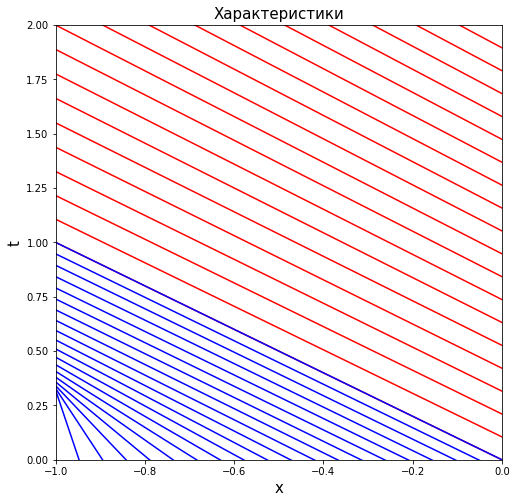

In [2]:
K = 20
x, t = np.linspace(-1, 0, K), np.linspace(0, 2, K)

def t1(x0, x):
    return  -(1 + (np.cos(np.pi*x0/2))**2)/(2*np.cos(np.pi*x0/2))*(x-x0)

def t2(t0, x):
    return t0 - (1 + (1+0.5*np.arctan(t0))**2)/(2 + np.arctan(t0))*x
    
fig = plt.figure(figsize =(8 ,8))
ax = fig.gca(xlim=(-1, 0), ylim=(0, 2)) 
plt.title('Характеристики', fontsize=15)
plt.ylabel('t', fontsize=15)
plt.xlabel('x', fontsize=15)

for i in range(K):
  ax.plot(x , t1(x[i] ,x) , color = "blue");
  ax.plot(x , t2(t[i] ,x), color = "red");

Заметим, что в области $-1 \leq x < 0$ на промежутке времени $0 < t < 1$ характеристики не пересекаются. Будем искать решение в этой области во избежание опрокидывания волны.

## Разностная сетка

Введем в расчетной области равномерную сетку:

$$\overline{\omega_{h,\tau}}=\big\{x_n= (N-1-n) h, t_m=m\tau, n=\overline{0,N-1}, m=\overline{0,M-1}\big\},$$

где $h = \frac{1}{N-1}$, $\tau = \frac{1}{M-1}$ - шаги по координате и времени соответственно, $N,M$ - число узлов по осям $x$ и $t$ соответственно.

Перепишем исходное уравнение в дивергентном виде:

$$\frac{\partial u}{\partial t} +  
        \frac{\partial}{\partial x}(-\ln({1 + u^{2})}) = 0$$

Введем на $\overline{\omega_{h,\tau}}$ сеточную функцию: $y_n^m=u(x_n,t_m)$. Также удобно ввести вспомогательную функцию: $F_n^m=F(y_n^m)=-\ln(1+(y_n^m)^2)$

Для построения разностной схемы будем пользоваться трёхточечным шаблоном вида: 

<center><img src=https://i.imgur.com/UQXGajP.png="130"></center>

Для линейного уравнения переноса он является абсолютно устойчивым, а разностный оператор аппроксимирует дифференциальный с первым порядком точности $O(h+\tau)$. 

Разностная схема для исходной задачи имеет следующий вид:

$$\left\{ \begin{array}{} \frac{y_n^m-y_n^{m-1}}{\tau}+\frac{F_{n+1}^m-F_n^m}{h}=0, \ (x,t) \in \omega_{h,\tau} \\ y_{N-1}^m=1 + \frac{1}{2} arctg\ t \\ y_n^0=\cos{\frac{\pi x}{2}} \end{array} \right.$$

Можно переписать первое уравнение этой системы в виде:

$$f(y_n^m)=0$$

Найдем корень этого уравнения итерационным методом Ньютона:

$${y^{m}_{n}}^{(s+1)} = {y^{m}_{n}}^{(s)} - \frac{f({y^{m}_{n}}^{(s)})}{f'({y^{m}_{n}}^{(s)})}$$

С заданой точностью $ \epsilon $: $$ | {y^{m}_{n}}^{(s+1)} - {y^{m}_{n}}^{(s)} | \leq \epsilon $$

### Основной код программы:

In [20]:
def F(u):
  return -np.log(1+u**2)

def dF(u):
  return -2*u/(1 + u**2)

def f(u, a, b, τ, h):
  return (u - a)/τ + (F(b) - F(u))/h

def df(u, τ, h):
  return 1/τ - dF(u)/h

def newton(a, b, ε, τ, h):
  result = b
  d = 1
  while(d > ε):
      y = result
      result = y - f(y, a, b, τ, h)/df(y, τ, h)
      d = np.abs(y - result)
  return result

def solve(N, ε):
  xmin, xmax = -1, 0
  tmin, tmax = 0, 1
  u = np.zeros((N, N), dtype=float)
  x = np.linspace(xmin, xmax, N)
  t = np.linspace(tmin, tmax, N)
  h = float(xmax-xmin)/(N-1)
  τ = float(tmax-tmin)/(N-1)
  u[N-1, :] = 1 + 0.5*np.arctan(t)
  u[:, 0] = np.cos(np.pi*x/2)

  for i in range(N-2, -1, -1):
      for j in range(1, N):
          u[i, j] = newton(u[i, j-1], u[i+1, j], ε, τ, h)
  return x, t, u

def table_pwot_6graphs(project):
  fig = plt.figure(figsize = (12,18))
  ax1 = fig.add_subplot(321, projection=project)
  ax2 = fig.add_subplot(322, projection=project)
  ax3 = fig.add_subplot(323, projection=project)
  ax4 = fig.add_subplot(324, projection=project)
  ax5 = fig.add_subplot(325, projection=project)
  ax6 = fig.add_subplot(326, projection=project)
  return [ax1, ax2, ax3, ax4, ax5, ax6]

## Результаты вычислений для различных значений числа узлов:

In [22]:
P = [5, 10, 50, 200, 1000, 5000]
ε = 1e-12
x, t, u = [], [], []
for k in range(6):
  temp = solve(P[k], ε)
  x.append(temp[0])
  t.append(temp[1])
  u.append(temp[2])

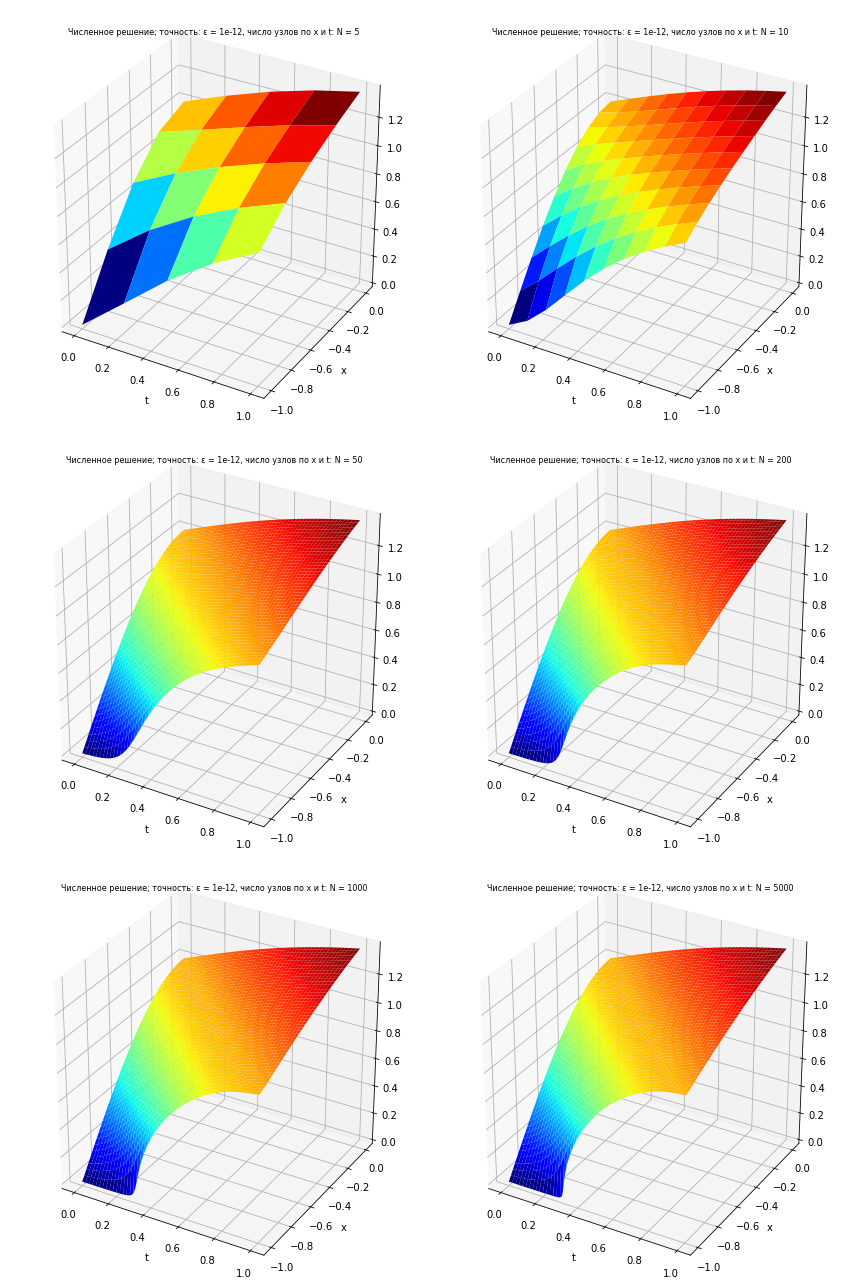

In [23]:
ax = table_pwot_6graphs('3d')
for k in range(6):
  xx, tt = np.meshgrid(t[k], x[k])
  surf = ax[k].plot_surface(xx, tt, u[k], cmap='jet')
  ax[k].set_xlabel('t', fontsize=10)
  ax[k].set_ylabel('x', fontsize=10)
  ax[k].set_title(f'Численное решение; точность: ε = {ε}, число узлов по x и t: N = {P[k]}', fontsize=8)

plt.tight_layout()

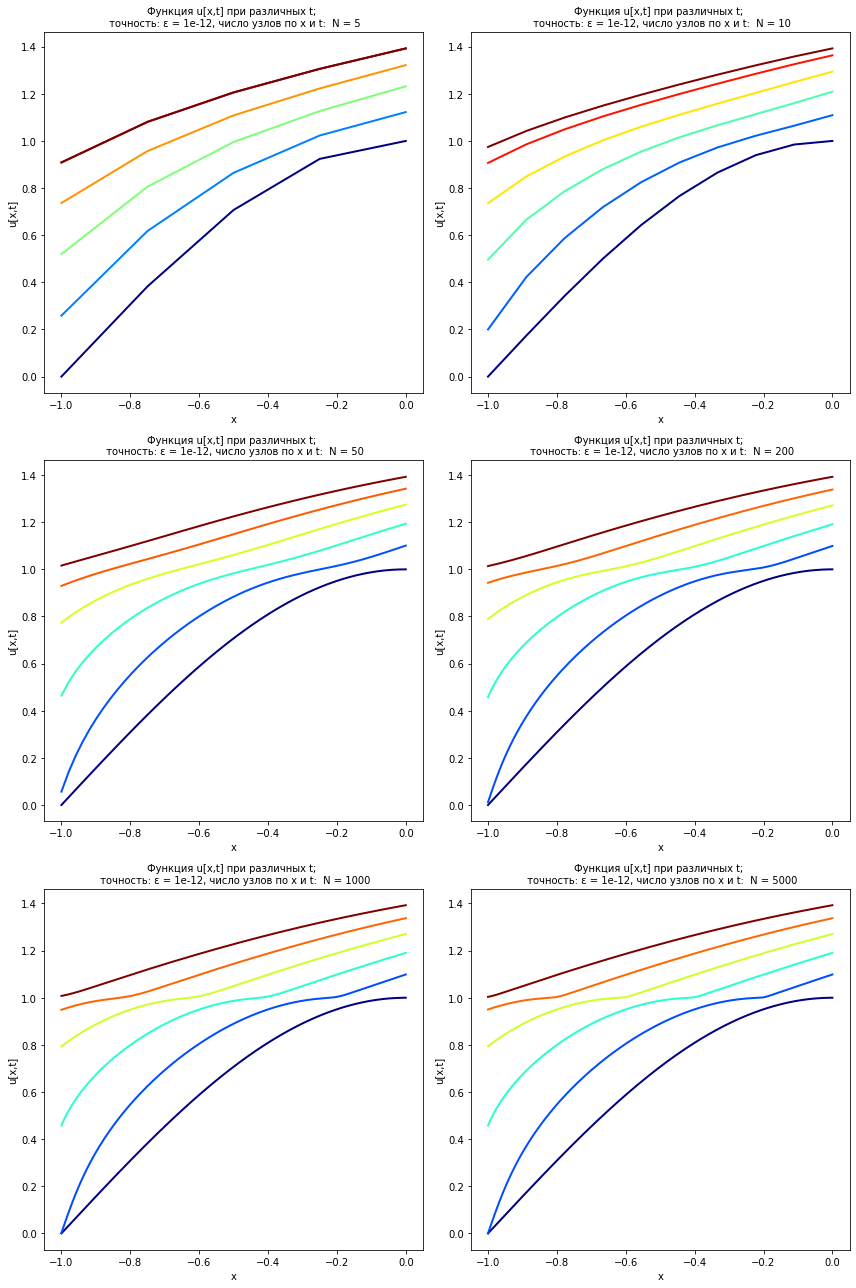

In [24]:
ax = table_pwot_6graphs(None)
for k in range(6):
  ax[k].set_xlabel('x', fontsize=10)
  ax[k].set_ylabel('u[x,t]', fontsize=10)
  ax[k].set_title(f'Функция u[x,t] при различных t; \n точность: ε = {ε}, число узлов по x и t:  N = {P[k]}', fontsize=10)
  colors = plt.cm.jet(np.linspace(0,1,P[k]))

  line_n = list(range(0, P[k]+1, int(P[k]/5)))
  line_n[-1] -= 1
  for e in line_n:
    ax[k].plot(x[k], u[k][:,e], lw=2, color=colors[e])

plt.tight_layout()